<div style="background-color: #d1a8ed; color: black; border: 5px solid #9038b5; padding: 10px;">
  <h1>Clipart Generator</h1>
  <ul>
    <li>Data comes from the 
      <a href="https://www.kaggle.com/datasets/vishesh1211/clipart?resource=download-directory" target="_blank" style="color: blue;">Kaggle Clipart Dataset</a>.
    </li>
    <li>Here are the 
      <a href="https://github.com/USFCA-MSDS/MSDS-631-GenAI" target="_blank" style="color: blue;">project instructions</a>.
    </li>
    <li>Here is the helper notebook 
      <a href="https://github.com/USFCA-MSDS/MSDS-634/blob/main/VAE.ipynb" target="_blank" style="color: blue;">for VAEs</a>.
    </li>
  </ul>
</div>

---

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Imports & Functions</h1>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import Subset

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Data Preprocessing</h1>
</div>

# View Data

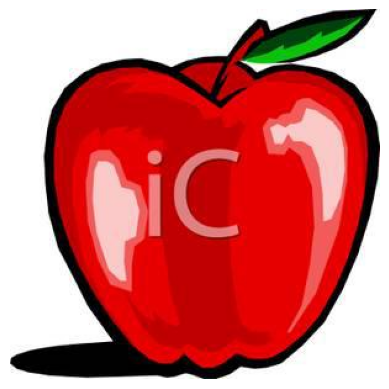

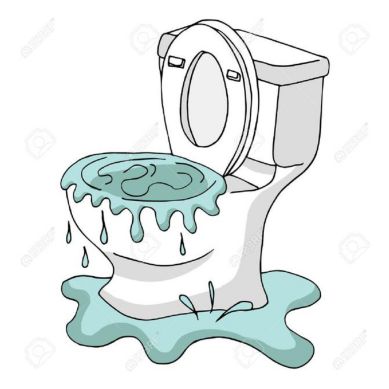

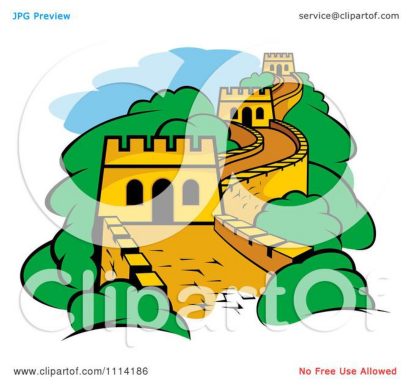

In [2]:
def view_image(image_path):
    """
    Load and display an image using PIL and matplotlib.
    
    Parameters
    ----------
        - image_path (str): Path to the image file

    Returns
    -------
        - None, displays image

    """
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.show()


view_image("clipart/apple/clipart_009_000003.jpg")
view_image("clipart/toilet/clipart_315_000017.jpg")
view_image("clipart/The_Great_Wall_of_China/clipart_310_000008.jpg")

# Load Data for Training

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='clipart/', transform=transform)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# If want to use subset
indices = list(range(900, 910)) 
subset_dataset = Subset(dataset, indices)
dataloader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=True)

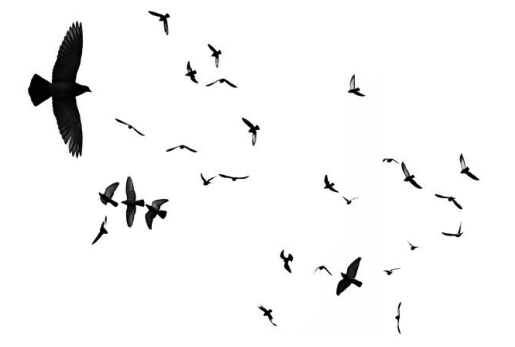

In [4]:
view_image(dataset.samples[900][0])

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Model Implementation</h1>
</div>

In [5]:
class ConvVAE(nn.Module):
    """
    A convolutional variational autoencoder (ConvVAE) for generating clipart images from a learned latent space.

    Attributes
    ----------
        - latent_dim (int): Dimensionality of the latent space.
        - encoder (nn.Sequential): Convolutional encoder network.
        - fc_mu (nn.Linear): Linear layer to produce mean of the latent space.
        - fc_logvar (nn.Linear): Linear layer to produce log variance of the latent space.
        - fc_decode (nn.Linear): Linear layer to expand latent vector to decoder input.
        - decoder (nn.Sequential): Convolutional decoder network.
    
    Methods
    -------
        - reparameterize(mu, logvar): Samples latent vector from mean and log variance using reparameterization trick.
        - forward(x): Passes input x through encoder, samples latent space, and reconstructs image.
    """
     
    def __init__(self, latent_dim=16):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h_dec = self.fc_decode(z)
        x_recon = self.decoder(h_dec)
        return x_recon, mu, logvar

In [6]:
def train_vae(model_num, latent_dim, lr, num_epochs=400):
    """ 
    Trains a convolutional variational autoencoder (ConvVAE) on the clipart dataset with given hyperparameters.

    Parameters
    ----------
        - model_num (int): Model number used for saving the trained model checkpoint.
        - latent_dim (int): Dimensionality of the latent space.
        - lr (float): Learning rate for the optimizer.
        - num_epochs (int, optional): Number of training epochs (default=10).

    Returns
    -------
        - total_losses (list): List of total loss values for each epoch.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = ConvVAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    criterion = nn.BCELoss(reduction='sum')
    recon_losses, kl_losses, total_losses = [], [], []

    print('===========================================================')
    print(f"Model {model_num} (latent={latent_dim}, lr={lr})")
    print('===========================================================\n')
    
    for epoch in tqdm(range(num_epochs)):
        vae.train()
        running_recon_loss, running_kl_loss = 0.0, 0.0
        for images, _ in dataloader:
            images = images.to(device)
            optimizer.zero_grad()
            recon_images, mu, logvar = vae(images)
            recon_loss = criterion(recon_images, images)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss
            loss.backward()
            optimizer.step()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()

        recon_losses.append(running_recon_loss / len(dataset))
        kl_losses.append(running_kl_loss / len(dataset))
        total_losses.append((running_recon_loss + running_kl_loss) / len(dataset))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}\n-------")
            print(f"Recon: {recon_losses[-1]:.6f} KL: {kl_losses[-1]:.6f} Total: {total_losses[-1]:.6f}\n")

    # Save model
    os.makedirs("models", exist_ok=True)
    torch.save(vae.state_dict(), f"models/model{model_num}.pt")
    print(f"Saved as models/model{model_num}.pt\n")
    return recon_losses, kl_losses, total_losses

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Methods</h1>
</div>

In [7]:
latent_dims = [8, 32, 500]
lrs = [1e-3, 5e-4]
all_losses = []

model_num = 1
for latent_dim in latent_dims:
    for lr in lrs:
        recon_losses, kl_losses, total_losses = train_vae(model_num, latent_dim, lr)
        all_losses.append((model_num, latent_dim, lr, recon_losses, kl_losses, total_losses))
        model_num += 1

Model 1 (latent=8, lr=0.001)



  0%|          | 0/400 [00:00<?, ?it/s]

  1%|▏         | 5/400 [00:00<00:09, 43.11it/s]

Epoch 0
-------
Recon: 0.438360 KL: 0.000001 Total: 0.438361



 27%|██▋       | 107/400 [00:01<00:05, 54.33it/s]

Epoch 100
-------
Recon: 0.299118 KL: 0.002300 Total: 0.301417



 52%|█████▏    | 209/400 [00:03<00:03, 53.35it/s]

Epoch 200
-------
Recon: 0.273843 KL: 0.003279 Total: 0.277122



 77%|███████▋  | 307/400 [00:05<00:01, 47.98it/s]

Epoch 300
-------
Recon: 0.264335 KL: 0.003315 Total: 0.267650



100%|██████████| 400/400 [00:07<00:00, 52.18it/s]


Saved as models/model1.pt

Model 2 (latent=8, lr=0.0005)



  2%|▏         | 6/400 [00:00<00:07, 54.36it/s]

Epoch 0
-------
Recon: 0.438926 KL: 0.000001 Total: 0.438927



 27%|██▋       | 108/400 [00:02<00:05, 54.97it/s]

Epoch 100
-------
Recon: 0.299126 KL: 0.003063 Total: 0.302189



 52%|█████▎    | 210/400 [00:03<00:03, 56.54it/s]

Epoch 200
-------
Recon: 0.281372 KL: 0.003444 Total: 0.284817



 78%|███████▊  | 312/400 [00:05<00:01, 54.16it/s]

Epoch 300
-------
Recon: 0.265916 KL: 0.003451 Total: 0.269367



100%|██████████| 400/400 [00:07<00:00, 54.24it/s]


Saved as models/model2.pt

Model 3 (latent=32, lr=0.001)



  2%|▏         | 6/400 [00:00<00:07, 54.28it/s]

Epoch 0
-------
Recon: 0.437649 KL: 0.000004 Total: 0.437653



 27%|██▋       | 108/400 [00:02<00:05, 49.73it/s]

Epoch 100
-------
Recon: 0.301271 KL: 0.003093 Total: 0.304364



 52%|█████▎    | 210/400 [00:04<00:03, 51.78it/s]

Epoch 200
-------
Recon: 0.275756 KL: 0.004850 Total: 0.280607



 76%|███████▋  | 306/400 [00:05<00:01, 52.41it/s]

Epoch 300
-------
Recon: 0.261067 KL: 0.004286 Total: 0.265353



100%|██████████| 400/400 [00:07<00:00, 50.91it/s]


Saved as models/model3.pt

Model 4 (latent=32, lr=0.0005)



  2%|▏         | 6/400 [00:00<00:07, 55.08it/s]

Epoch 0
-------
Recon: 0.428994 KL: 0.000005 Total: 0.428999



 27%|██▋       | 108/400 [00:01<00:05, 55.02it/s]

Epoch 100
-------
Recon: 0.303509 KL: 0.003584 Total: 0.307093



 51%|█████     | 204/400 [00:03<00:03, 50.64it/s]

Epoch 200
-------
Recon: 0.294578 KL: 0.004312 Total: 0.298890



 78%|███████▊  | 311/400 [00:05<00:01, 52.40it/s]

Epoch 300
-------
Recon: 0.273134 KL: 0.005513 Total: 0.278648



100%|██████████| 400/400 [00:07<00:00, 53.48it/s]


Saved as models/model4.pt

Model 5 (latent=500, lr=0.001)



  1%|▏         | 5/400 [00:00<00:09, 41.61it/s]

Epoch 0
-------
Recon: 0.423338 KL: 0.000074 Total: 0.423412



 26%|██▋       | 105/400 [00:02<00:06, 42.29it/s]

Epoch 100
-------
Recon: 0.296008 KL: 0.003847 Total: 0.299856



 51%|█████▏    | 205/400 [00:04<00:04, 42.02it/s]

Epoch 200
-------
Recon: 0.282497 KL: 0.004807 Total: 0.287304



 76%|███████▋  | 305/400 [00:07<00:02, 42.05it/s]

Epoch 300
-------
Recon: 0.265208 KL: 0.006029 Total: 0.271237



100%|██████████| 400/400 [00:09<00:00, 41.62it/s]


Saved as models/model5.pt

Model 6 (latent=500, lr=0.0005)



  1%|          | 4/400 [00:00<00:10, 37.77it/s]

Epoch 0
-------
Recon: 0.426827 KL: 0.000060 Total: 0.426887



 26%|██▋       | 106/400 [00:02<00:07, 40.13it/s]

Epoch 100
-------
Recon: 0.299953 KL: 0.004210 Total: 0.304163



 52%|█████▏    | 207/400 [00:05<00:04, 39.70it/s]

Epoch 200
-------
Recon: 0.285906 KL: 0.004983 Total: 0.290889



 76%|███████▋  | 305/400 [00:07<00:02, 41.65it/s]

Epoch 300
-------
Recon: 0.272158 KL: 0.006140 Total: 0.278298



100%|██████████| 400/400 [00:09<00:00, 40.31it/s]

Saved as models/model6.pt



<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Experiments & Results</h1>
</div>

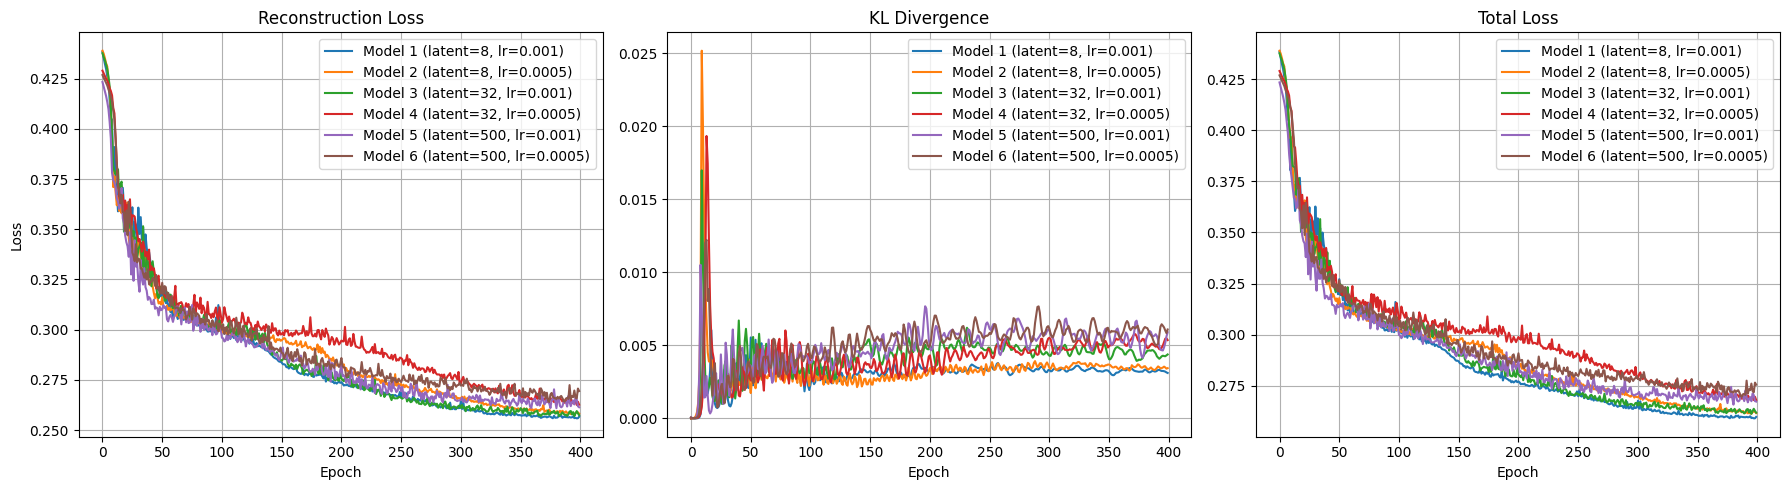

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

for model_num, latent_dim, lr, recon_losses, kl_losses, total_losses in all_losses:
    axs[0].plot(recon_losses, label=f"Model {model_num} (latent={latent_dim}, lr={lr})")
    axs[1].plot(kl_losses, label=f"Model {model_num} (latent={latent_dim}, lr={lr})")
    axs[2].plot(total_losses, label=f"Model {model_num} (latent={latent_dim}, lr={lr})")

axs[0].set_title('Reconstruction Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('KL Divergence')
axs[1].set_xlabel('Epoch')
axs[1].legend()
axs[1].grid(True)

axs[2].set_title('Total Loss')
axs[2].set_xlabel('Epoch')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [9]:
def load_model_and_generate(model_num):
    """ 
    Loads a trained VAE model and generates a grid of new clipart images.

    Parameters
    ----------
        - model_num (int): The model number corresponding to a saved model in the 'models/' directory.

    Returns
    -------
        - None: Displays a grid of generated images using matplotlib.
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model2latent = {
        1: 8,    # Model 1: latent_dim=8
        2: 8,    # Model 2: latent_dim=8
        3: 32,   # Model 3: latent_dim=32
        4: 32,   # Model 4: latent_dim=32
        5: 500,  # Model 5: latent_dim=500
        6: 500   # Model 6: latent_dim=500
    }
    
    latent_dim = model2latent[model_num]
    vae = ConvVAE(latent_dim=latent_dim).to(device)
    vae.load_state_dict(torch.load(f"models/model{model_num}.pt"))
    vae.eval()

    with torch.no_grad():
        z = torch.randn(64, latent_dim).to(device)
        h_dec = vae.fc_decode(z)
        samples = vae.decoder(h_dec).cpu()
        grid = make_grid(samples, nrow=8, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.title(f'Generated Samples (Model {model_num})')
        plt.show()

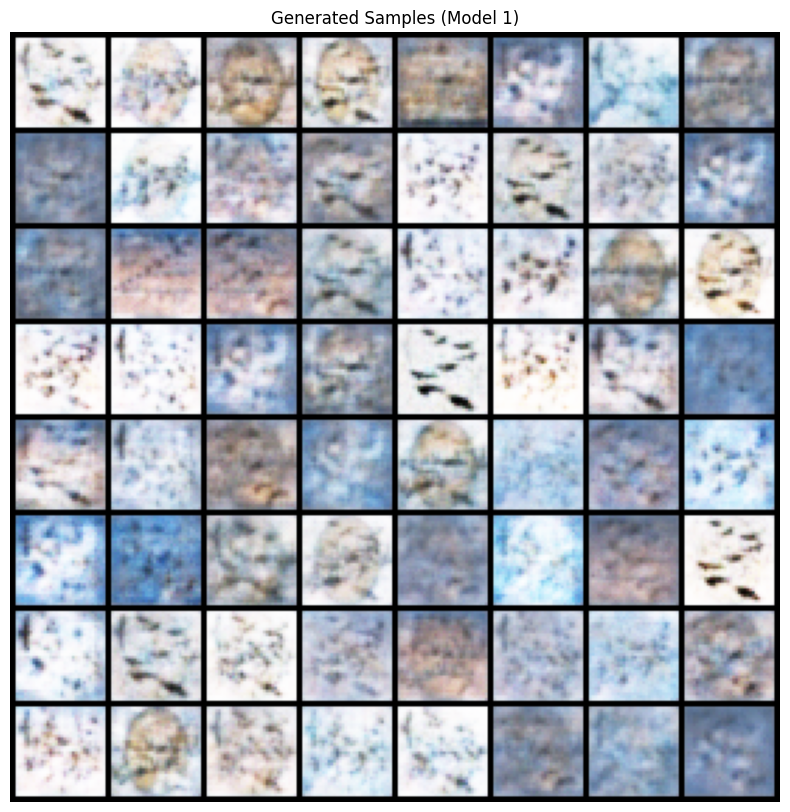

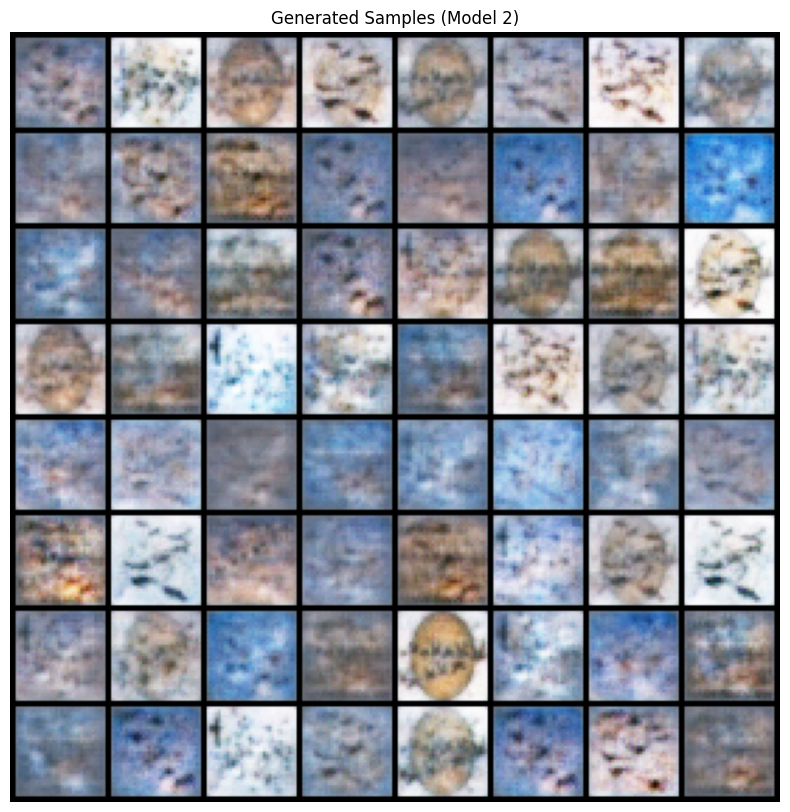

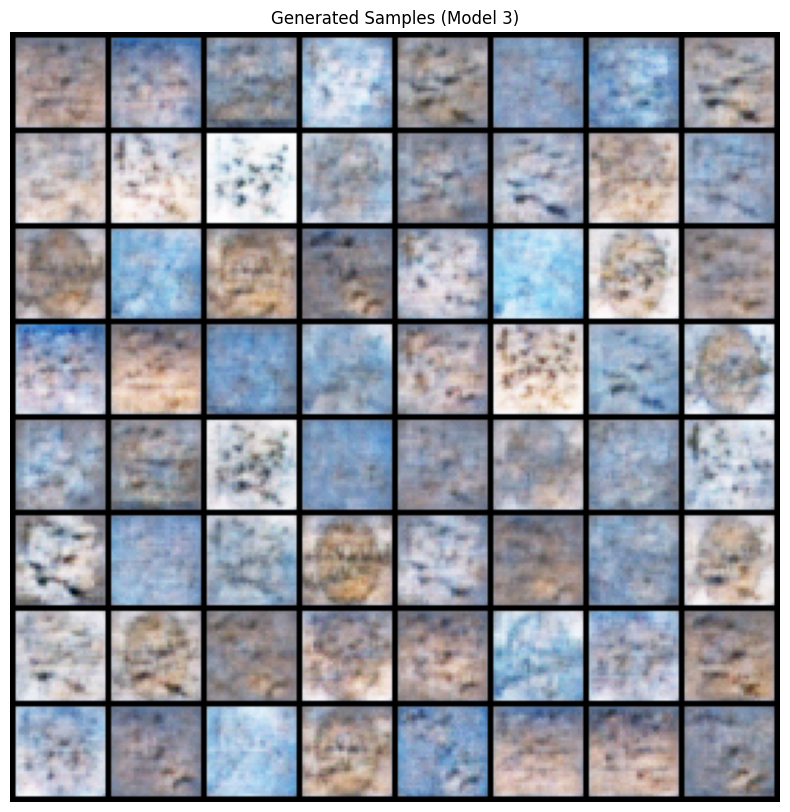

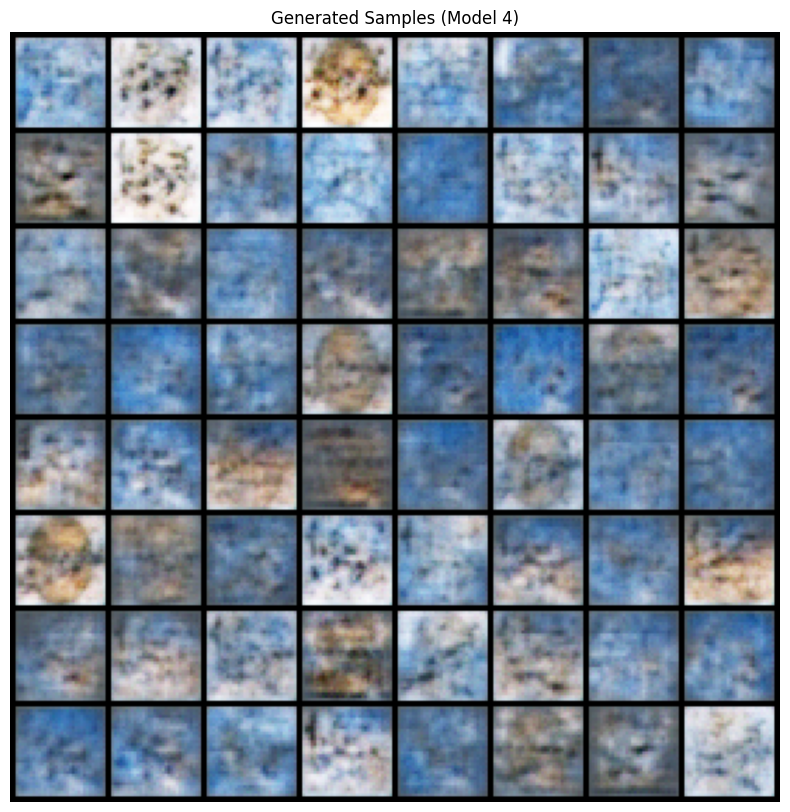

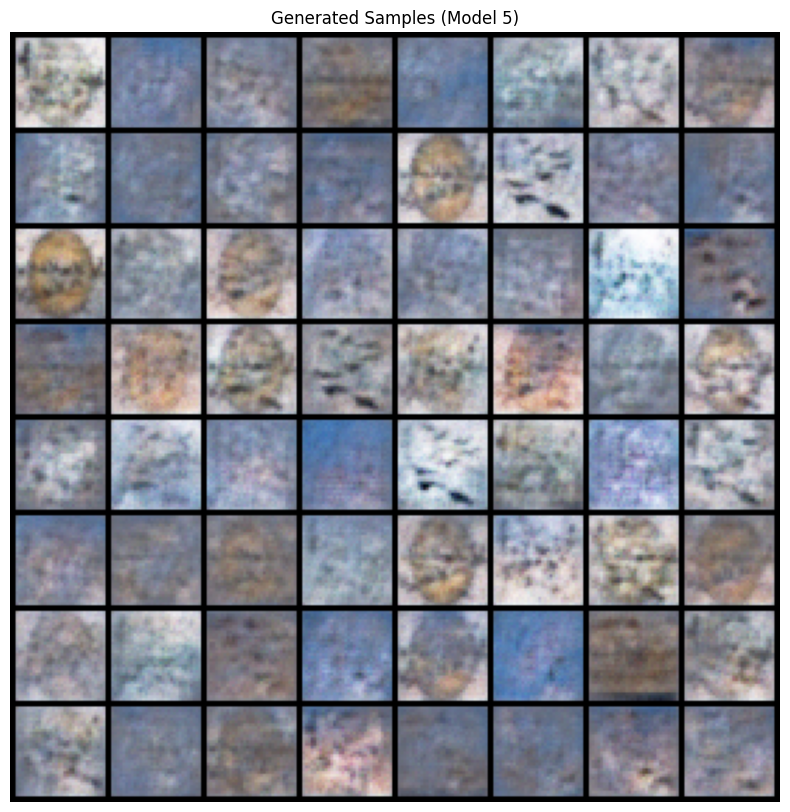

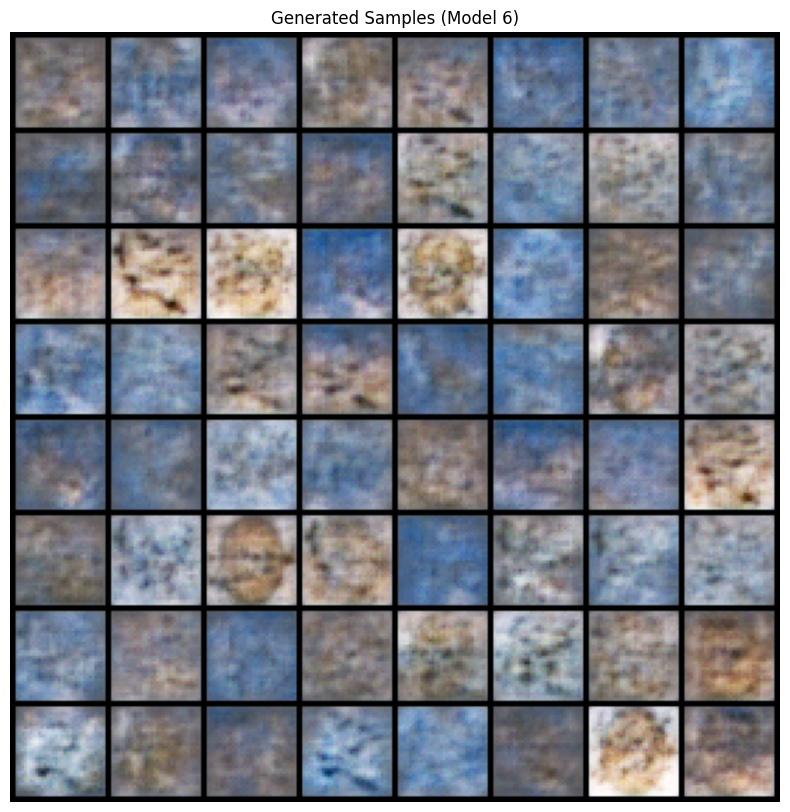

In [10]:
for i in range(1, 7):
    load_model_and_generate(i)